---
title: Stable diffusion using 🤗 Hugging Face - Looking under the hood
author: Aayush Agrawal
date: "2022-11-05"
categories: [Stable Diffusion]
image: "underthehood.png"
format:
    html:
        code-fold: false
        number-sections: true
---

> An introduction into what goes on in the pipe function of  🤗 [hugging face diffusers library](https://github.com/huggingface/diffusers) `StableDiffusionPipeline` function.

This is my second post of the Stable diffusion series, if you haven't checked out the first one, you can read it here - <br>
1. **Part 1** - [Introduction to Stable diffusion using 🤗 Hugging Face](https://aayushmnit.com/posts/2022-11-02-StabeDiffusionP1/2022-11-02-StableDiffusionP1.html).


In this post, we will understand the basic components of a stable diffusion pipeline and their purpose. Later we will reconstruct `StableDiffusionPipeline.from_pretrained` function using these components. Let's get started - 

<figure align = "center">
<img src="./underthehood.png" style="width:100%">
<figcaption align = "center">
        Fig. 1: This image was generated by 🤗 Stable diffusion model using the "a scientist looking under the hood of a car realistic 4k image" prompt.
</figcaption>
</figure>

## Introduction

Diffusion models as seen in the previous post can generate high-quality images. Stable diffusion models are a special kind of diffusion model called the **Latent Diffusion** model. They have first proposed in this paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752). The original Diffusion model tends to consume a lot more memory, so latent diffusion models were created which can do the diffusion process in lower dimension space called `Latent` Space. On a high level, diffusion models are machine learning models that are trained to `denoise` random Gaussian noise step by step, to get the result i.e., `image`. In `latent diffusion`, the model is trained to do this same process in a lower dimension. <br>

There are three main components in latent diffusion - <br>

1. A text encoder, in this case, a [CLIP Text encoder](https://openai.com/blog/clip/) 
2. An autoencoder, in this case, a Variational Auto Encoder also referred to as VAE 
3. A [U-Net](https://arxiv.org/abs/1505.04597)

Let's dive into each of these components and understand their use in the diffusion process. The way I will be attempting to explain these components is by talking about them in the following three stages - <br>

1. **_The Basics: What goes in the component and what comes out of the component_** - This is an important, and key part of the [top-down learning approach](https://www.fast.ai/posts/2016-10-08-teaching-philosophy.html) of understanding "the whole game"
2. **_Deeper explanation using 🤗 code._** - This part will provide more understanding of what the model produces using the code
3. **_What's their role in the Stable diffusion pipeline_** - This will build your intuition around how this component fits in the Stable diffusion process. This will help your intuition on the diffusion process


## CLIP Text Encoder

### Basics - What goes in and out of the component?

CLIP(Contrastive Language–Image Pre-training) text encoder takes the text as an input and generates text embeddings that are close in latent space as it may be if you would have encoded an image through a CLIP model.

<figure align = "center">
    <img src="./clip_image.png" style="width:100%">
<figcaption align = "center">
        Fig. 2: CLIP text encoder 
</figcaption>
</figure>

### Deeper explanation using 🤗 code

Any machine learning model doesn't understand text data. For any model to understand text data, we need to convert this text into numbers that hold the meaning of the text, referred to as `embeddings`. The process of converting a text to a number can be broken down into two parts - <br>
1. **_Tokenizer_** - Breaking down each word into sub-words and then using a lookup table to convert them into a number <br>
2. **_Token_To_Embedding Encoder_** - Converting those numerical sub-words into a representation that contains the representation of that text <br>

Let's look at it through code. We will start by importing the relevant artifacts.

In [1]:
import torch, logging

## disable warnings
logging.disable(logging.WARNING)  

## Import the CLIP artifacts 
from transformers import CLIPTextModel, CLIPTokenizer

## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

Let's initialize a prompt and tokenize it.

In [3]:
prompt = ["a dog wearing hat"]
tok =tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt") 
print(tok.input_ids.shape)
tok

torch.Size([1, 77])


{'input_ids': tensor([[49406,   320,  1929,  3309,  3801, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

A `tokenizer` returns two objects in the form of a dictionary - <br>
1. **_`input_ids`_** - A tensor of size 1x77 as one prompt was passed and padded to 77 max length. _`49406`_ is a start token, _`320`_ is a token given to the word "a", _`1929`_ to the word dog, _`3309`_ to the word wearing, _`3801`_ to the word hat, and _`49407`_ is the end of text token repeated till the pad length of 77. <br>
2. **_`attention_mask`_** - `1` representing an embedded value and `0` representing padding.

In [4]:
for token in list(tok.input_ids[0,:7]): print(f"{token}:{tokenizer.convert_ids_to_tokens(int(token))}")

49406:<|startoftext|>
320:a</w>
1929:dog</w>
3309:wearing</w>
3801:hat</w>
49407:<|endoftext|>
49407:<|endoftext|>


So, let's look at the `Token_To_Embedding Encoder` which takes the `input_ids` generated by the tokenizer and converts them into embeddings - 

In [5]:
emb = text_encoder(tok.input_ids.to("cuda"))[0].half()
print(f"Shape of embedding : {emb.shape}")
emb

Shape of embedding : torch.Size([1, 77, 768])


tensor([[[-0.3887,  0.0229, -0.0522,  ..., -0.4902, -0.3066,  0.0673],
         [ 0.0292, -1.3242,  0.3074,  ..., -0.5264,  0.9766,  0.6655],
         [-1.5928,  0.5063,  1.0791,  ..., -1.5283, -0.8438,  0.1597],
         ...,
         [-1.4688,  0.3113,  1.1670,  ...,  0.3755,  0.5366, -1.5049],
         [-1.4697,  0.3000,  1.1777,  ...,  0.3774,  0.5420, -1.5000],
         [-1.4395,  0.3137,  1.1982,  ...,  0.3535,  0.5400, -1.5488]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>)

As we can see above, each tokenized input of size 1x77 has now been translated to 1x77x768 shape embedding. So, each word got represented in a 768-dimensional space.

### What's their role in the Stable diffusion pipeline 

Stable diffusion only uses a CLIP trained encoder for the conversion of text to embeddings. This becomes one of the inputs to the U-net. On a high level, CLIP uses an image encoder and text encoder to create embeddings that are similar in latent space. This similarity is more precisely defined as a [Contrastive objective](https://arxiv.org/abs/1807.03748). For more information on how CLIP is trained, please refer to this [Open AI blog](https://openai.com/blog/clip/).

<figure align = "center">
    <img src="./clip_contrastive.png" style="width:100%">
<figcaption align = "center">
        Fig. 3: CLIP pre-trains an image encoder and a text encoder to predict which images were paired with which texts in our dataset. Credit - [OpenAI](https://openai.com/blog/clip/)
</figcaption>
</figure>

## VAE - Variational Auto Encoder

### Basics - What goes in and out of the component?

An autoencoder contains two parts - <br>
1. `Encoder` takes an image as input and converts it into a low dimensional latent representation <br>
2. `Decoder` takes the latent representation and converts it back into an image


<figure align = "center">
<img src="./vae_image.png" style="width:100%">
<figcaption align = "center">
        Fig. 4: A Variational autoencoder. Original bird [pic credit](https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg).
</figcaption>
</figure>

As  we can see above, the Encoder acts like a compressor that squishes the image into lower dimensions and the decoder recreates the original image back from the compressed version.

:::{.callout-note}
Encoder-Decoder compression-decompression is not lossless. 
:::

### Deeper explanation using 🤗 code

Let's start looking at VAE through code. We will start by importing the required libraries and defining some helper functions.

In [6]:
#| code-fold: true
## To import an image from a URL
from fastdownload import FastDownload

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms

## Basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading a VAE model
from diffusers import AutoencoderKL
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

Let's download an image from the internet.

Dimension of this image: (512, 512, 3)


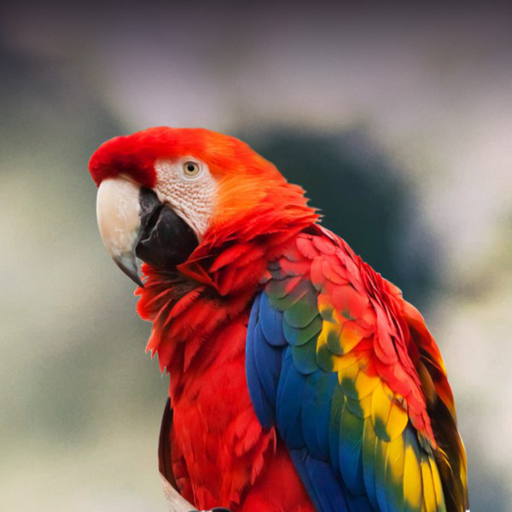

In [7]:
p = FastDownload().download('https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg')
img = load_image(p)
print(f"Dimension of this image: {np.array(img).shape}")
img

<figcaption align = "center">
        Fig. 5: Original bird [pic credit](https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg). 
</figcaption>

Now let's compress this image by using the VAE encoder, we will be using the `pil_to_latents` helper function.

In [8]:
latent_img = pil_to_latents(img)
print(f"Dimension of this latent representation: {latent_img.shape}")

Dimension of this latent representation: torch.Size([1, 4, 64, 64])


As we can see how the VAE compressed a 3 x 512 x 512 dimension image into a 4 x 64 x 64 image. That's a compression ratio of 48x! Let's visualize these four channels of latent representations.

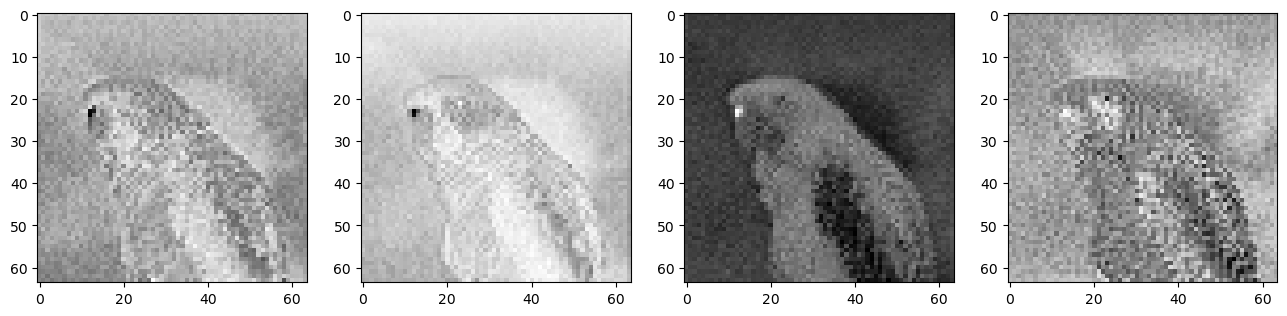

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent_img[0][c].detach().cpu(), cmap='Greys')

<figcaption align = "center">
        Fig. 6: Visualization of latent representation from VAE encoder. <br>
</figcaption>

This latent representation in theory should capture a lot of information about the original image. Let's use the decoder on this representation to see what we get back. For this, we will use the `latents_to_pil` helper function.

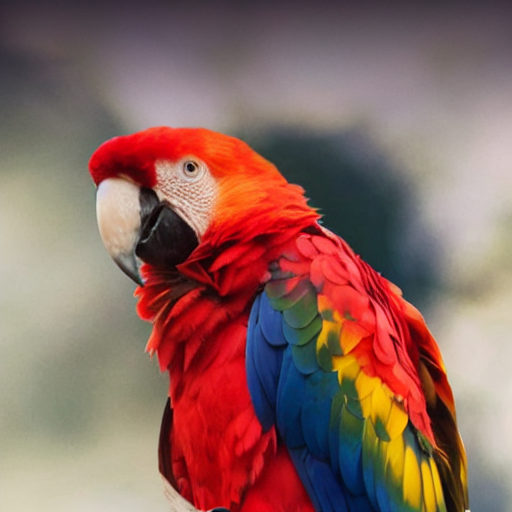

In [10]:
decoded_img = latents_to_pil(latent_img)
decoded_img[0]

<figcaption align = "center">
        Fig. 7: Visualization of decoded latent representation from VAE decoder. <br>
</figcaption>

As we can see from the figure above VAE decoder was able to recover the original image from a 48x compressed latent representation. That's impressive!

:::{.callout-note}
If you look closely at the decoded image, it's not the same as the original image, notice the difference around the eyes. That's why VAE encoder/decoder is not a lossless compression.
:::

###  What's their role in the Stable diffusion pipeline

Stable diffusion can be done without the VAE component but the reason we use VAE is to reduce the computational time to generate High-resolution images. The latent diffusion models can perform diffusion in this _latent space_ produced by the VAE encoder and once we have our desired latent outputs produced by the diffusion process, we can convert them back to the high-resolution image by using the VAE decoder. To get a better intuitive understanding of Variation Autoencoders and how they are trained, read [this blog by Irhum Shafkat](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf).



## U-Net

### Basics - What goes in and out of the component?

The U-Net model takes two inputs - <br>
1. `Noisy latent` or `Noise`- Noisy latents are latents produced by a VAE encoder (in case an initial image is provided) with added noise or it can take pure noise input in case we want to create a random new image based solely on a textual description <br>
2. `Text embeddings` - CLIP-based embedding generated by input textual prompts <br>

The output of the U-Net model is the predicted noise residual which the input noisy latent contains. In other words, it predicts the noise which is subtracted from the noisy latents to return the original de-noised latents.

<figure align = "center">
<img src="./unet_image.png" style="width:100%">
<figcaption align = "center">
        Fig. 8: A U-Net representation.
</figcaption>
</figure>

### Deeper explanation using 🤗 code

Let’s start looking at U-Net through code. We will start by importing the required libraries and initiating our U-Net model.

In [95]:
from diffusers import UNet2DConditionModel, LMSDiscreteScheduler

## Initializing a scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
## Setting number of sampling steps
scheduler.set_timesteps(51)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

As you may have noticed from code above, we not only imported `unet` but also a `scheduler`. The purpose of a `schedular` is to determine how much noise to add to the latent at a given step in the diffusion process. Let's visualize the schedular function - 

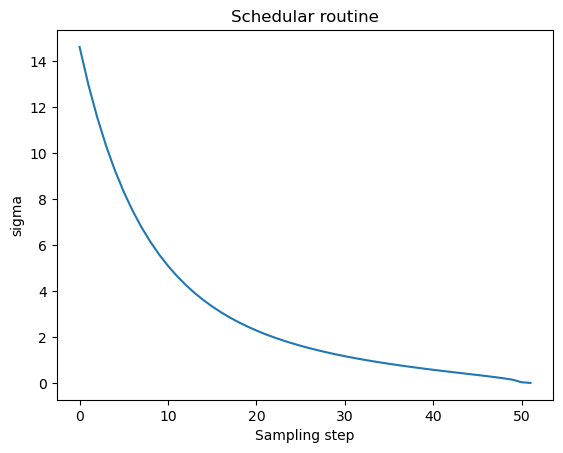

In [98]:
#| code-fold: true
plt.plot(scheduler.sigmas)
plt.xlabel("Sampling step")
plt.ylabel("sigma")
plt.title("Schedular routine")
plt.show()

<figcaption align = "center">
        Fig. 9: Sampling schedule visualization.
</figcaption>

The diffusion process follows this sampling schedule where we start with high noise and gradually denoise the image. Let's visualize this process - 

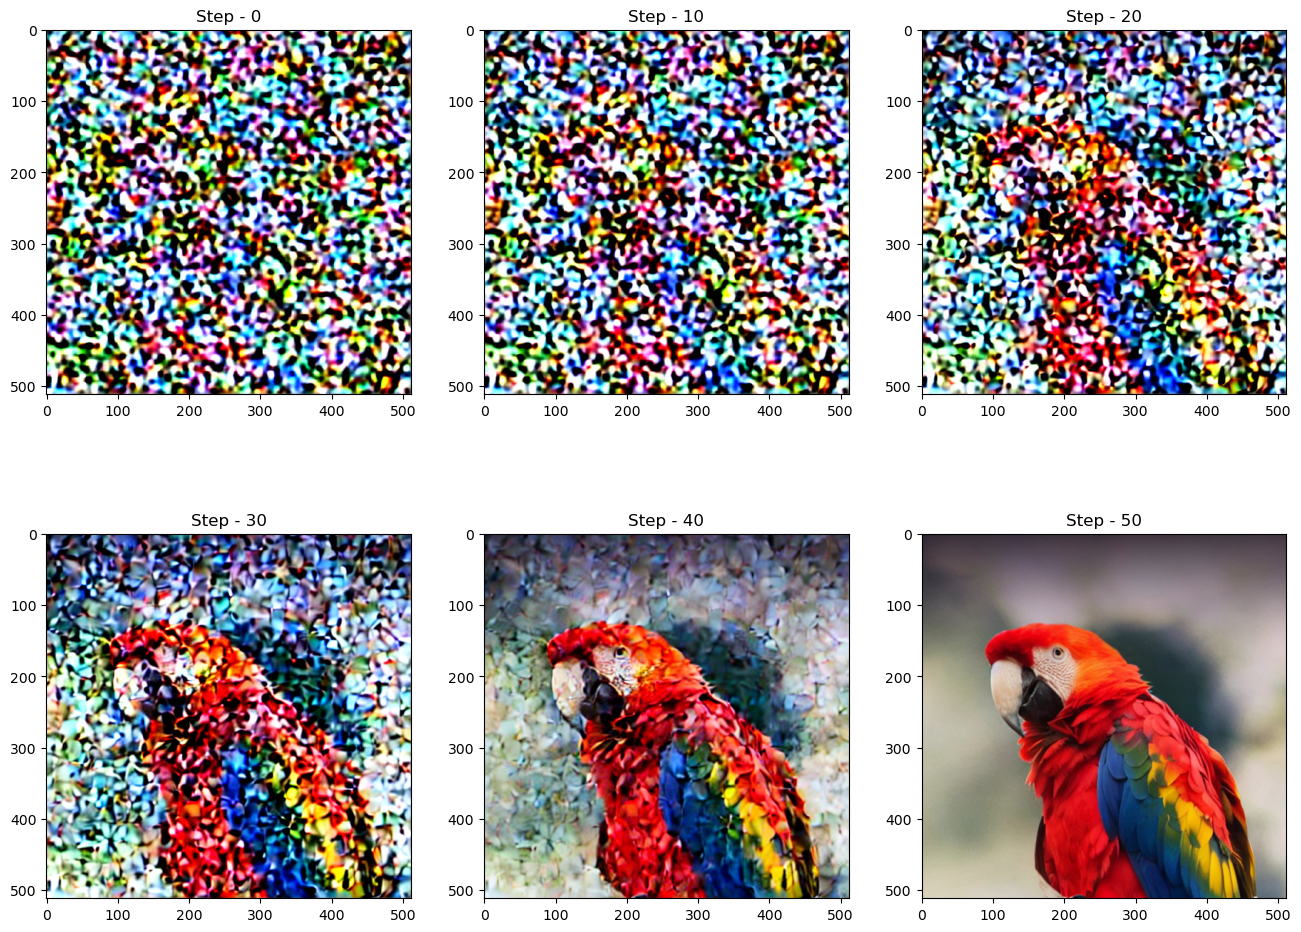

In [92]:
#| code-fold: true
noise = torch.randn_like(latent_img) # Random noise
fig, axs = plt.subplots(2, 3, figsize=(16, 12))
for c, sampling_step in enumerate(range(0,51,10)):
    encoded_and_noised = scheduler.add_noise(latent_img, noise, timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
    axs[c//3][c%3].imshow(latents_to_pil(encoded_and_noised)[0])
    axs[c//3][c%3].set_title(f"Step - {sampling_step}")

<figcaption align = "center">
        Fig. 10: Noise progression through steps.
</figcaption>

Let's see how a U-Net removes the noise from the image. Let's start by adding some noise to the image.

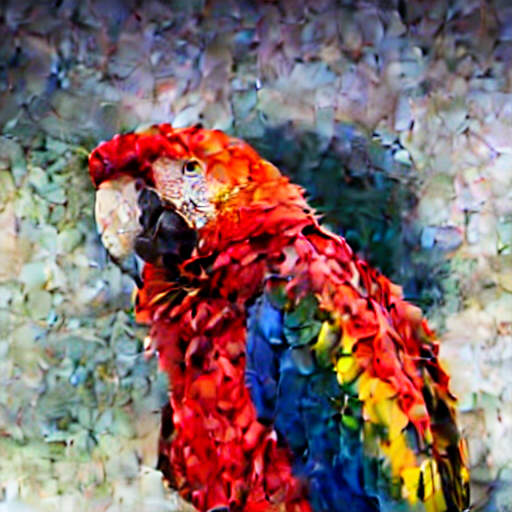

In [152]:
#| code-fold: true
encoded_and_noised = scheduler.add_noise(latent_img, noise, timesteps=torch.tensor([scheduler.timesteps[40]]))
latents_to_pil(encoded_and_noised)[0]

<figcaption align = "center">
        Fig. 11: Noised Input fed to the U-Net.
</figcaption>

Let's run through U-Net and try to de-noise this image.

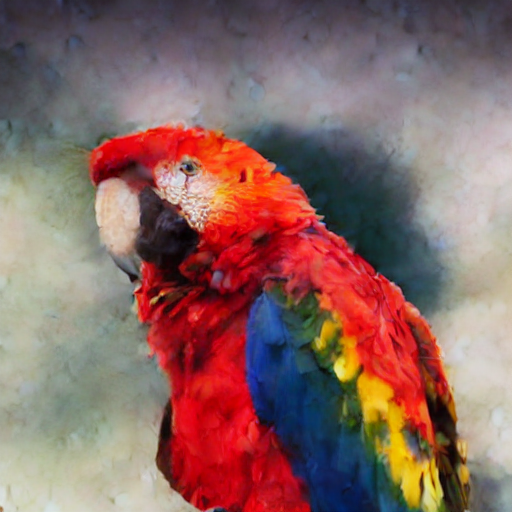

In [153]:
## Unconditional textual prompt
prompt = [""]

## Using clip model to get embeddings
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad(): 
    text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0]
    
## Using U-Net to predict noise    
latent_model_input = torch.cat([encoded_and_noised.to("cuda").float()]).half()
with torch.no_grad():
    noise_pred = unet(latent_model_input, 40, encoder_hidden_states=text_embeddings)["sample"]

## Visualize after subtracting noise 
latents_to_pil(encoded_and_noised- noise_pred)[0]

<figcaption align = "center">
        Fig. 12: De-Noised Output from U-Net
</figcaption>

As we can see above the U-Net output is clearer than the original noisy input passed. 

###  What's their role in the Stable diffusion pipeline

Latent diffusion uses the U-Net to gradually subtract noise in the latent space over several steps to reach the desired output. With each step, the amount of noise added to the latents is reduced till we reach the final de-noised output. U-Nets were first introduced by [this paper](https://arxiv.org/abs/1505.04597) for Biomedical image segmentation. The U-Net has an encoder and a decoder which are comprised of ResNet blocks. The stable diffusion U-Net also has cross-attention layers to provide them with the ability to condition the output based on the text description provided. The Cross-attention layers are added to both the encoder and the decoder part of the U-Net usually between ResNet blocks. You can learn more about this U-Net architecture [here](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).

## Conclusion

In this post, we saw the key components of a Stable diffusion pipeline i.e., CLIP Text encoder, VAE, and U-Net. In the next post, we will look at the diffusion process using these components. Read the [next part here](https://aayushmnit.com/posts/2022-11-07-StableDiffusionP3/2022-11-07-StableDiffusionP3.html).

I hope you enjoyed reading it, and feel free to use my code and try it out for generating your images. Also, if there is any feedback on the code or just the blog post, feel free to reach out on [LinkedIn](https://www.linkedin.com/in/aayushmnit/) or email me at aayushmnit@gmail.com.

## References

- [Stable Diffusion with 🧨 Diffusers](https://huggingface.co/blog/stable_diffusion)
- [Getting Started in the World of Stable Diffusion](https://bipinkrishnan.github.io/posts/getting-started-in-the-world-of-stable-diffusion/)